# Toxic comments - Zina Bazarbashi

The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [1]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [2]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [3]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    toxic_data = pd.read_csv(fn)
    if (not test):
        # add an indicator for any toxic, severe toxic, obscene, threat, insult, or indentity hate
        toxic_data['any_toxic'] = (toxic_data['toxic'] + toxic_data['severe_toxic'] + toxic_data['obscene'] + toxic_data['threat'] + toxic_data['insult'] + toxic_data['identity_hate'] > 0)
    print("toxic_data is:", type(toxic_data))
    print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in toxic_data:")
    print(toxic_data.dtypes, "\n")
    print("the first 10 rows in toxic_data:")
    print(toxic_data.head(5))
    if (not test):
        print("The rate of 'toxic' Wikipedia comments in the dataset: ")
        print(toxic_data['any_toxic'].mean())
        # this identifies the percentage of the data that is in ANY way toxic = 0.1016 meaning roughly 10% 

    # vectorize Bag of Words from review text; as sparse matrix
#     hv = HashingVectorizer(n_features=2 ** 19, alternate_sign=False)
#     X_hv = hv.fit_transform(toxic_data.comment_text)
#     print("Shape of HashingVectorizer X:")
#     print(X_hv.shape)
     # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 19, alternate_sign=False)
        X_hv = hv.fit_transform(toxic_data.comment_text)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(toxic_data.comment_text)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    #calculates frequencies then divides it by inverse so it calculates weight
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
        
    # create additional quantitative features
    # SEE HOW THIS AFFECTS THE DATA BY TRYING IT WITH AND WITHOUT
    # features from Amazon.csv to add to feature set
    toxic_data['word_count'] = toxic_data['comment_text'].str.split(' ').str.len()
    toxic_data['punc_count'] = toxic_data['comment_text'].str.count("\.")

    X_quant_features = toxic_data[["word_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
#     sc = StandardScaler(with_mean=False)
#     X = sc.fit_transform(X_matrix)
#     print(X.shape)
#     if (not test):
#         y = toxic_data['any_toxic']
 
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = toxic_data['any_toxic']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(toxic_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, toxic_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
         #the raw shape meaning without the bag of words and hashing vectorizer
        print(X_raw_train.shape) 
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [4]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []


# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='toxiccomments_train.csv', my_random_seed=23)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 9 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
any_toxic          bool
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  any_toxic  
0             0        0     

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [5]:
# THIS WHOLE THING IS COMMENTED OUT CAUSE IM NOT A FAN OF THIS MODEL.
# from sklearn import linear_model
# ols = linear_model.SGDClassifier(loss="squared_loss")
# ols.fit(X_train, y_train)

# ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
# ols_performance_train.compute_measures()
# print(ols_performance_train.performance_measures)

### MODEL: SVM, linear

In [38]:
from sklearn import linear_model
svm = linear_model.SGDClassifier(loss='hinge', penalty='elasticnet', alpha=0.0001, max_iter=20000, shuffle=True, average=150, n_iter_no_change=5, class_weight='balanced', learning_rate='optimal' )
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 12945, 'Neg': 114711, 'TP': 12624, 'TN': 105357, 'FP': 9354, 'FN': 321, 'Accuracy': 0.9242103778905809, 'Precision': 0.5743925743925744, 'Recall': 0.9752027809965238, 'desc': 'svm_train'}


### MODEL: logistic regression

In [44]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log', penalty='elasticnet', alpha=0.0001,l1_ratio=0.15, max_iter=20000, shuffle=True, average=150, n_iter_no_change=5, class_weight='balanced')
#i added a really low alpha value to increase generalization, and saw that when i added the average the recall increased
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 12945, 'Neg': 114711, 'TP': 12682, 'TN': 106815, 'FP': 7896, 'FN': 263, 'Accuracy': 0.9360860437425581, 'Precision': 0.6162892409369229, 'Recall': 0.9796832753959057, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [15]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB(alpha=0.0001, fit_prior=False, class_prior=None)
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 12945, 'Neg': 114711, 'TP': 12783, 'TN': 103833, 'FP': 10878, 'FN': 162, 'Accuracy': 0.9135175784921978, 'Precision': 0.5402561176619755, 'Recall': 0.9874855156431055, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [10]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 12945, 'Neg': 114711, 'TP': 12846, 'TN': 114596, 'FP': 115, 'FN': 99, 'Accuracy': 0.9983236197280191, 'Precision': 0.9911272278373582, 'Recall': 0.9923522595596755, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [11]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier(alpha=0.0001, fit_intercept=True, normalize=False, copy_X=True, max_iter=1000, tol=0.001)
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 12945, 'Neg': 114711, 'TP': 10773, 'TN': 114582, 'FP': 129, 'FN': 2172, 'Accuracy': 0.9819749952998684, 'Precision': 0.9881673087506879, 'Recall': 0.8322132097334878, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [12]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(n_estimators=10, criterion='entropy', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

{'Pos': 12945, 'Neg': 114711, 'TP': 11949, 'TN': 114701, 'FP': 10, 'FN': 996, 'Accuracy': 0.992119446011155, 'Precision': 0.9991638096830838, 'Recall': 0.9230590961761298, 'desc': 'rdf_train'}


### ROC plot to compare performance of various models and fits

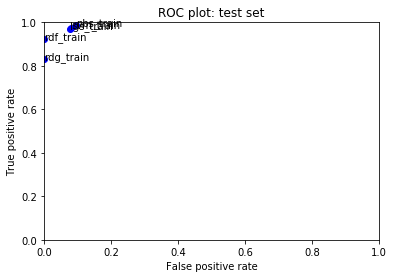

In [39]:
fits = [svm_performance_train, lgs_performance_train, nbs_performance_train, rdg_performance_train, rdf_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

nbs_predictions = nbs.predict(X_train)

### let's look at some false positives:

In [18]:
# false positives

print("Examples of false positives:")

import random, time
nbs_predictions = nbs.predict(X_train)

for i in range(0, len(nbs_predictions)):  #when uploading to github, make the length shorter than the entire list
    if (nbs_predictions[i] == 1):
        if (X_raw_train.iloc[i]['any_toxic'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 10% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')


Examples of false positives:
424
Forgetting is an unconscious act, Dr. K. Pretending to forget is something different...
* * * * * * * * * 
529
The Rock isn't a blood relation of any of the Anoai family.
* * * * * * * * * 
824
"I am really really sorry, okay you win I promise to stop using twinkle, please guys just one more chance I'm begging you please, I am truly truly sorry —123 "
* * * * * * * * * 
967
Alright. what i think am going to do type up an article on word in my own words following the procedure of other profiles already on here with all the info i know. i can copy that unto this place then we can work on the rest on here???? ~~
* * * * * * * * * 
1012
POV on God entry 

Thank you for pointing out as such; I'm admittedly late to the conversation, and was hesitant to make the reversion. There are too many people who want to push their own lack of religion on those of us who are Christian or otherwise spiritually inclined.
* * * * * * * * * 
1295
"

I posted the intent to do

19660
Agreed. Extra thanks from me, for sending a number of such checks your way. (I just did one below; forgive me?) That medal is deservedly gold.
* * * * * * * * * 
19774
Thank you for the help. They really trumped up the charges and made up ones out of thin air. Like sock-puppeting...no proof whatsoever. They didn't care to remove that charge either.
* * * * * * * * * 
19862
"No one has ""forced"" you to be the small person you are who finds it necessary to stick your nose where it doesn't belong and into affairs about which you have no knowledge. Not sure how you live with yourself.

"
* * * * * * * * * 
19946
Personal Attacks 

What is going on with Lefty's user page? Why is what he's doing a personal attack? I think I may have a similar problem but I'm not sure.
* * * * * * * * * 
20017
You really are something else. 

You know that? Why you and administrators continue to insist on thinking that I'm Fragments of Jade or whatever name that woman uses is still a mystery to me. You

33052
Wow!  I missed this little personal attack.  Good show!
* * * * * * * * * 
33471
forehead-metal 

The guys got the biggest forehead you can ever see. with each new album it grows LOL
* * * * * * * * * 
33616
why don't you go outside an play?- () Wolfkeeper (Talk)
* * * * * * * * * 
33667
Just pointing out that if you intend to keep arguing this thing for a whole month, you're going to have a lot more people pissed off at you than just me. — ''''''  —
* * * * * * * * * 
33881
I really fail to see how I made a personal attack. I replied to various attacks made on me clarifying, and yet I am blocked? Everything I wrote is true and I do feel this block is unwarranted and uncalled for. There is no merits unless you believe that the personal attacks, backbiting and claims made against me are true - thus encouraging incivility, while keeping me from defending myself by stating the facts.
* * * * * * * * * 
33972
Salvation 

Do not worry you are but a lost lamb the Lord will forgive you


55971
Mmmmm... goats! 

216.164.33.62
* * * * * * * * * 
56009
ah ha... I'll get on it....
* * * * * * * * * 
56535
Lovely! 

216.164.33.62
* * * * * * * * * 
57239
"

Wanted articles
Emmett Watson, to include a great explanation of the term ""Lesser Seattle"" or a Lesser Seattle article.  "
* * * * * * * * * 
57545
I think (obviously), if an edit is in bad taste and came from an IP, it obviously needs to be blocked.
* * * * * * * * * 
57632
I am sorry. Please don't block me.
* * * * * * * * * 
57675
mo - i wont accept that - youve said i have violated terms and conditions and wont say what one82.34.185.176
* * * * * * * * * 
58094
"
'it does read as if ""Christian = bigot""'.  Really?  Re-read all my arguments, it is about ""faith-based"" actions and not the faith itself, and certainly not the entire community."
* * * * * * * * * 
58509
POD & SHIITHEAD 

Be polite 
Assume good faith 
Avoid personal attacks 
Be welcoming 

I haven't seen you follow any of these guidelines. ~*~ M ~*~ 67

69811
"***Actually what is happening is Wikipedia editors are doing what they should not be doing - trying to apply their own opinions and what is essentially original research. Watkins is referred to as a pedophile by multiple highly reliable sources. All of these sources are referring to him as a pedophile per the clinical sense: one who is sexually attracted to children.  It is not ""our place"" to accept or reject this information. Are there reliable sources anywhere that are arguing the man is not a pedophile? If that were the case, I can see why this would be up for debate. But it's not - nobody is claiming the man is not a pedophile. Additionally, before you argue that ""we don't know whether Watkins is sexually attracted to children,"" I highly suggest you actually take a look at the facts of the case and all the activities he has been involved. If you can't be bothered to do that because it sickens you, then fine, but don't claim that there's just no way for anyone to know. YO

82265
Thank you for not threatening me.
* * * * * * * * * 
82478
Thought you wasn't coming back to this article???
* * * * * * * * * 
82618
"

 Metalloid 

Hello. Do you know what are the ""still less frequently appearing elements"" in metalloid you talked about in the box floating at the right? It could be useful to add those (and add sources where each element is listed as a metalloid).   "
* * * * * * * * * 
82707
Have you actually read the text concerning KLT? It says that KLT was falsely accused! Read before you revert!.
* * * * * * * * * 
82876
"
 Fair enough, after all if we all were great minds who thought alike how dull things would be! -  One ping only "
* * * * * * * * * 
82883
"

 Yeah Sarek are you going to do something? ~Talk "
* * * * * * * * * 
83451
Um, well perhaps youtube was a bad reference to prove my point because someone delted it.I will try to find a better source, but if people atleast looked at the video they could see it is true fact.
* * * * * * * * * 
83516

95963
LOL! that it is funny!
* * * * * * * * * 
96029
Need your help 

Dear Sikh Historian,

I would request all you all to please help me in exposing Sikh Scholar, who actually is an RSS sponsered person pretending to be Sikh, please see below the kind of statements he makes to me

Wow wow so the truth is finaly out....you have spoken like a true Hindu RSS wala......is that the way a scholar speaks...wow...(my answere to him)

(Sikh Scholars comments to me)....... stupid dumb FU*K MY great great great great grandfather was Mani Singh the greatest of Sikh matrys. Its scum like you that needs to be executed. You deserve execution - you stupid dumb fu*k everyone in my family over 500 members are Baptized Khalsa SIKHS. We have been Khalsa Sikhs for over 300 years you dumb fu*ker. Because you have insulted me and broken the teachings of the Guru Granth Sahib you deserve death -you dumb fu*ker.Sikh scholar (talk) 

(my answere to him)...Now I will be after you to expose all your RSS gang pr

111819
Why would you blank it?
WHY CANT I HAVE A CONVERSATION WITH MY BROS ON WIKIPEDIA?
* * * * * * * * * 
111895
Look JD I really need your help. Can you help me?
* * * * * * * * * 
111954
Sockpuppet accounts 

What sockpuppet accounts? And why don't you people just let me do my job?
* * * * * * * * * 
111973
Hi.  I reverted your recent change to RuneScape.  While I don't care really that you moved your site from medium traffic to high traffic...when you moved it to high traffic you removed the link to another high traffic site.
* * * * * * * * * 
111979
I am sorry plz dont block me
* * * * * * * * * 
112371
haha that was great!! -
* * * * * * * * * 
112861
I'll decide what I want to decide, thanks.  190.44.133.67
* * * * * * * * * 
113197
It is unfortunate that Wikipedia does not have better administrators, who do not insist on ignorance.
* * * * * * * * * 
113287
"

Talkback

 bark dig "
* * * * * * * * * 
113516
Why do you keep reverting a perfectly reasonable, minor edit? Are you

126333
Does anyone know about the album change from Trouble Man to Trouble Man: Heavy Is The Head?? I saw it on his youtube channel and I just wanted to know. Thanks.
* * * * * * * * * 
126363
she was found dead at her own house not at a friends apartment
* * * * * * * * * 
127091
, such as a 2-3 month ban from Wikipedia. (You were warned 3 times!!)
* * * * * * * * * 
127121
Hope it is soon and painful!!!
* * * * * * * * * 
127490
Will do, but you have an anti-semitic problem here. I think you need to handle that...
* * * * * * * * * 


In [17]:
lgs_predictions = lgs.predict(X_train)
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(lgs_predictions)):  #when uploading to github, make the length shorter than the entire list
    if (lgs_predictions[i] == 1):
        if (X_raw_train.iloc[i]['any_toxic'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')



Examples of false positives:
570
Ha, next time I have some sort of template problem, do I have to get a sock out of the drawer to post on your talk page? )
* * * * * * * * * 
624
((unblock)) cause i said so
* * * * * * * * * 
1580
"I'll give you the benefit of the doubt and assume you meant to say that he's a brilliant at distorting history in such a way that the ignorant may take his words seriously. But ""suberb historian""? The fact that he deliberately distorts history, in my view, disqualifies him as being any legitimate historian whatsoever, be it a brilliant or mediocre one. Brilliant liars in no sense qualify as historians, despite their brilliance. Would you not agree that at the very least, to be qualified as a bona fide historian, even a mediocre one, one must at the very least provide reasonably verifiable evidence of what one purports to be ""history""? David Irving may be clever, perhaps even brilliant, yet due the fact that he deliberately distorts history, in my mind di

16293
":Ali, as I've wrote, none of those authors are aware of many important details, such as Kurekchay Treaty - an official and legal treaty which defined the entry of Karabakh into Russian empire. At the same time, the khan of Sheki too signed a similar treaty, for example. I know Michael Croissant, and his book is full of mistakes and errors, his book doesn't mean much in this regard. His mistakes are too gross  the Russo-Iran war started in 1806, whilst Karabakh became part of Russia in 1805 before such a war. Meanwhile, Tim Potier is a good legal expert, and it is surprizing to see him write that. But everyone is entitled to errors and his was due to lack of resources - he was limited as a scholar in variety of materials and legal status of Karabakh in 19th century was not his objective  the 20th century was. Anyways, I do not know the khans of Iran in the south and which treaties they concluded with British. If they did it in the Zand period, they probably had full legal right a

23511
"

Narcissist much?

""We require some better publicity"" you said on the Paul L. page. Who the Hell is ""we""? You don't speak for me or millions of other Christians or scientists, who made you anyone's spokesperson? Are you noteworthy? CLEARLY no more than Paul L. Get lost Pharisee.  "
* * * * * * * * * 
23555
"
That ANI was crushed all too soon! Would've been more fun to have given it a bit more rope...   Imperatrix Mundi "
* * * * * * * * * 
23606
INC has gotten worse... 

Now Emico's back in full force, flinging insults left and right and the worst thing is that he thinks he's doing nothing wrong. For his own good and the good of Wikipedia, we need to find a way to protect that article and stop this once and for all.
* * * * * * * * * 
23611
Is that ISP/IP slop over more possible is we both use Qwest to access the Internet?
* * * * * * * * * 
24438
Is that right Blix1900? Funny, you say  you don't care what my views are yet you go to to great lengths to reply on my talk page

39949
The first recorded use of this name is with Thomas Pink of London c.1994.
* * * * * * * * * 
40145
Of course.I reckon you have nothing  to do.
* * * * * * * * * 
40227
A disgusting block 

The block of yourself by KrakatoaKatie was hocrriffic. If you would like wiki-revenge, please leave a message here
* * * * * * * * * 
40348
"

..read lihaas version of upa article with lies about somnath ""claiming"" things and somnath ""inserting his name"" in the UPA article..wikipedians can also notice the above user's utter disregard for putting citations and her/his inability to practise what she/he preaches to me (see above for..""uncited, and original research"" and compare his reinserted version full of lies on july 25) !! she/he says ""we should use discussion before that""  but he/she replaces wiki edits ""en bloc"" with his/her fantasies..may be he/she ""reinserts lies obsessively"". i dont know why !!... i am not a british english user nor do i profess to be an english expert like l

48636
[ am a good friend of the guys at less than jake and was only playing around with the guys i promoise you will not vandilize any of there pages ever again}
* * * * * * * * * 
48799
I like how you tell Wikipedia admins what the hell they can and cannot do. Maybe I should head over to SD.net and tell Wong what he is allowed to do with the site. Anonymous
* * * * * * * * * 
49058
leave me the **** alone and stop undoing every edit I do
* * * * * * * * * 
49169
Cumulus cloud, you should respond of your disruptive and genuinely anal retentive action. Do you know a cumulus of what you are pouring on wikipedia?
* * * * * * * * * 
49203
Are you known as a sock puppet?
* * * * * * * * * 
49373
And articles are full of falsehoods, biases, myths passed for facts, etc.
* * * * * * * * * 
49424
"

  Statement on my block 

On 27 June I was asked by Thatcher to help deal with pro-paedo bias historical articles.  

I read your post on WR. I have just dealt with a rampant sockpuppeteer User:Burr

56060
K.F.A. 

why just cuz u dont agree doesnot make it nonsense ( )
* * * * * * * * * 
56238
"
I am not your friend, sorry. That said, I don't believe that I ever insinuated that YOUR edits were partisan. I noted that editing was going on which was partisan, and I believe that to be an accurate statement. In fact, a casual perusal of the edit history with regard to the ""retired / was forced to retire"" issue substantiates that. I have already stood behind my allegation above, and I continue to do so now. As far as evidence goes, I tender your complete lack of interest in any pages of any outgoing incumbents, all of which reflect the same status, beyond this one. Is this because you and West share a military background? Is it because both you and he are professed conservatives? I don't pretend to know, but as I stated, your interest in this page, and only this page, with regard to this concept is suggestive. I do not have a reactionary mentality. What I also do not have is a subservi

64239
I just tag it so some administrator can delete it.   (talk)
* * * * * * * * * 
64270
You left me hanging! Did you give her the razor? Did she need help? LOL
* * * * * * * * * 
64513
the world.  Just give it up mate you are a sad individual
* * * * * * * * * 
64640
"
  This makes more sense to me.  Mirv's comment is confusing to me...the Christian God is never lowercase either...the English equivalent of a lowercase-g god is, well, god.  So, will we say ""Christians believe that their god, God, does X"" or ""Christians believe that God does X"" (with perhaps an intro explaining who this ""God"" is)?  I much prefer the latter.  I trust no Muslim would want the sentence ""Muslims believe that their god Allah does X"", but would prefer a brief intro explaining who Allah is, followed by sentences like ""Muslims believe that Allah does X""."
* * * * * * * * * 
64835
"
A ""personal attack"" is generally something which involves a slur or a lie, not a pure confinement to an accurate desc

72320
Conflict of Interests 
On Talk:Oppss you have identified yourself as Gaurav Singh. On Oppss you identify Gaurav Singh as the founder of the company. That is a conflict of interests and I strongly advise you to stop trying to write about a subject you are so closely linked to.
* * * * * * * * * 
72576
"

 Interaction ban? 

You are the one who posted this. Does that make you the ""admin who imposed the ban"", or would it be someone else? I'm asking because I'm curious what the proper mechanism is (if any) for reporting possible violations of interaction bans. I asked at AN, and they told me to ask the admin who imposed the ban. ← What's up, Doc? carrots→ 
By my recollection, that rfc was re-closed by someone else. (Apparently, when they reverted the closure I had done, they neglected to place their own name on that page you linked to.)
Regardless, afaik, there is no restriction that places one admin solely as responsible for enforcing any user sanctions. And afaik, that's part of 

80043
"
Only in your rather ill-informed opinion. And Bloodofox, you could at least try and get your facts right before mouthing off again.  Corbett "
* * * * * * * * * 
80240
"
Agreed.  Satori Son "
* * * * * * * * * 
80335
No, here in the North of England we are such a bunch of degraded beings that we murder animals for amusement before each rugby game. Wake up.
* * * * * * * * * 
80539
Source! 

http://www.toonzone.net/forums/showthread.php?t=278990

+ The official MAD magazine.
* * * * * * * * * 
81605
Also you have that you are a checkuser on your WP:Userpage too.
* * * * * * * * * 
81846
OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES

87634
" 

Darry, Darry, Darry. Watched both programmes AND read both books? I feel for you mate. Why put yourself through the agony - especially of the books...
Seems to me that only something beginning with ""www.bbc.co.uk"" carries any weight on this site as a 'source', and theyre not about to go and ut out op-eds criticising the boorish Boorman and the whiney Mcgregor. You must know what I'm saying has more than a ring of truth - especially the laughable Davidhoff Cool Water campaign that McGregor cashed in with. I hope so otherwise you've had the wool well and truly pulled over your eyes..

How about this as a source - Amazon Reviews!

How about the amazon real name reviews
"
* * * * * * * * * 
88652
Arvanitic is the language of the Ancient Dorians
“The word punon means work in Arvanitika. Ponos (pain in Greek) means punon. Work
is painful. Do you see what I mean? Arvanitic is the language of the Ancient Dorians. We
are the first Greek tribes to have come to settle here.”  dodona
*

96372
Dear David Ruben   Try SourceWatch for a start . . .in addition to MSN.com ( Search Term: General Medical Council )...Then go back to the Wikipedia Article on the General Medical Council and appropriately list Abolish the General Medical Council (GMC) as one of the GMC's Notable Critics.

I have done it for you !!! So please thank me for it !!!

Thank you - UKDoctor
* * * * * * * * * 
96421
I like the book Hatchet.Everyone should read it if they are looking for a good book.Hatchet is a really good book.
* * * * * * * * * 
96621
Check out my picture 

68.248.73.3
* * * * * * * * * 
96787
Britney Spears disocgraphy
Stop making up random numbers for her album sales abd get proo she sold as much as she did. Her debut album nevr sold 14.7 million in the US. if it did, it would be No.2 on the soundscan list for best-selling albums in the US from 1999-2006. It only shipped 14 million. Her sophomore album would also be on the top 10 soundscan list, but it is not!!Stop reverting back to y

104864
ill be back O probs with another admin account
* * * * * * * * * 
104922
nikko smells  nikko smells  nikko smells  nikko smells  nikko smells  nikko smells  nikko smells  nikko smells  nikko smells  nikko smells  nikko smells  nikko smells  nikko smells  nikko smells  nikko smells  nikko smells  nikko smells  nikko smells  nikko smells  nikko smells  nikko smells  nikko smells    nikko smells  nikko smells  nikko smells  nikko smells  nikko smells  nikko smells  nikko smells  nikko smells  nikko smells  nikko smells  nikko smells  nikko smells  nikko smells  nikko smells  nikko smells  nikko smells  nikko smells  nikko smells  nikko smells  nikko smells  nikko smells  nikko smells    nikko smells  nikko smells  nikko smells  nikko smells  nikko smells  nikko smells  nikko smells  nikko smells  nikko smells  nikko smells  nikko smells  nikko smells  nikko smells  nikko smells  nikko smells  nikko smells  nikko smells  nikko smells  nikko smells  nikko smells  nikko smells  nikko 

112568
Racism, look it up.
* * * * * * * * * 
113192
No, I have reverted your undiscussed changes 3 times, I have not broken 3RR I would have to revert them again, if you want to complain then go to an administrator.
* * * * * * * * * 
113224
I would like also to politely say that this book is definitely reliable as in it each piece of info is referenced with the episode from which it comes. Moreover, it is a very popular book among who-fans, to whom the slightest error would be noticeable, and it is a culmination of over a decades research on this subject, hope this clears the matter up for you user:Ebyabe, though your point was definitely valid and I am glad to see that such things are checked. Thanks for justifying my source user:Flax5, very kind of you. Sorry I didn't reply sooner.
* * * * * * * * * 
114265
:'( How'd you see past my clever ruse? Your Critical Thinking Skills® must be pretty good. 0  And I'll cease my terribly unbecoming behavior immediantly.
* * * * * * * * * 
1145

120878
"and exactly which one of those was not appropriate to link to ""dubya""? -steve

"
* * * * * * * * * 
121346
Maybe I wasn't clear: legitimate criticism of a POV administrator is valid. Don't vandalize my edits and don't threaten me.
* * * * * * * * * 
121420
"

 so you unwatched the article? 

listen heres the deal see?

i mean real wikipedians and not ppl who delete legitimate sources theres only gonna be hate speech deleted so there

ARGH stop typing in riddles u gimme a headache with your chore to read long speeches if you wanna threaten me then just post a stop sign like the other ""smarter"" guy did

irrelevent 3 threats... etc

ahh yes thanks man that template is attracting attention ill delete it to be safe since it was a rethreat dont consider it to be legit im nowhere close to getting in trouble to be listening to the biased like of you btw the book is biased sure its there but almost all wrestlecrap is really literally what the name suggests

this is a war if they sta

In [128]:
svm_predictions = svm.predict(X_train)
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(svm_predictions)):  #when uploading to github, make the length shorter than the entire list
    if (svm_predictions[i] == 1):
        if (X_raw_train.iloc[i]['any_toxic'] == 0):
            if (random.uniform(0, 1) < 0.1): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')

#It may be that its using all caps and profuse use of punctuation is being learned as toxic
#i would like to re-iterate that some of the trained data is mis-labelled or bias!

Examples of false positives:
14614
Strong Support - Sad to see antisemitic opposing views.
* * * * * * * * * 
18412
I sincerely wish i could meet you chumps   
    
You freaks really get my goat. Etaonsh(still stuck in 1940's Europe), Firestar(firststatr Kung Fu extraordinaire), COvenantD(typical east coast jerk), Mibhofroovvsskskkety(russkie man frozen in USSR), Samuel Luo(weird lookin crazy), and crazy ol' Tomanandaaa!(brokeback mt.! u give w.hollywood a bad name!) Hey tom, when are you going to make a real citation? your scholarship is the worst i have ever seen. stay in your hole in the public library, transient!   
    
    
We know you have no lives and are failures, I really can't believe how much you guys are on this site. I have been away for awhile(thanks to some good old censorship courtesy of that advocate of free speech, Fristare, kung fu chump) but you have been here night and day it appears. It's like you are writing books on the Falun Gong page alone. Freaks!   
    
Ge

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [15]:
# ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
# ols_performance_test.compute_measures()
# print(ols_performance_test.performance_measures)

{'Pos': 3218, 'Neg': 28697, 'TP': 1509, 'TN': 14636, 'FP': 14061, 'FN': 1709, 'Accuracy': 0.505874980416732, 'Precision': 0.09691714836223507, 'Recall': 0.4689247980111871, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [40]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 3280, 'Neg': 28635, 'TP': 2813, 'TN': 24766, 'FP': 3869, 'FN': 467, 'Accuracy': 0.8641391195362682, 'Precision': 0.42098174199341515, 'Recall': 0.8576219512195122, 'desc': 'svm_test'}


### MODEL: logistic regression

In [45]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 3280, 'Neg': 28635, 'TP': 2769, 'TN': 24994, 'FP': 3641, 'FN': 511, 'Accuracy': 0.8699044336518879, 'Precision': 0.43198127925117, 'Recall': 0.8442073170731708, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [21]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 3280, 'Neg': 28635, 'TP': 2105, 'TN': 23320, 'FP': 5315, 'FN': 1175, 'Accuracy': 0.7966473445088517, 'Precision': 0.28369272237196763, 'Recall': 0.6417682926829268, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [22]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 3280, 'Neg': 28635, 'TP': 2139, 'TN': 27204, 'FP': 1431, 'FN': 1141, 'Accuracy': 0.9194109352968823, 'Precision': 0.5991596638655462, 'Recall': 0.6521341463414634, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [23]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 3280, 'Neg': 28635, 'TP': 1662, 'TN': 28484, 'FP': 151, 'FN': 1618, 'Accuracy': 0.9445715180949397, 'Precision': 0.9167126309983453, 'Recall': 0.5067073170731707, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [24]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 3280, 'Neg': 28635, 'TP': 991, 'TN': 28585, 'FP': 50, 'FN': 2289, 'Accuracy': 0.9267115776280745, 'Precision': 0.951969260326609, 'Recall': 0.3021341463414634, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

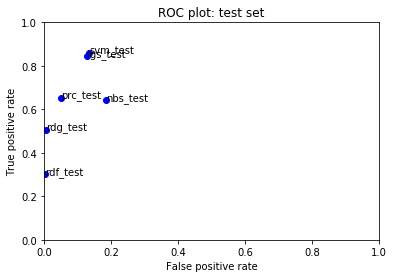

In [46]:
fits = [svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [47]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='toxiccomments_test.csv', my_random_seed=23, test=True)
print("Number of rows in the submission test set (should be 153,164): ")

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 153164 rows and 2 columns 

the data types for each of the columns in toxic_data:
id              object
comment_text    object
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3  00017563c3f7919a  :If you have a look back at the source, the in...
4  00017695ad8997eb          I don't anonymously edit articles at all.
Shape of HashingVectorizer X:
(153164, 524288)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0          72          10
1          13           1
2          16           0
3          38           3
4           7           1
5          16           2
6          31           4
7           6       

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [49]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = lgs.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

#I had a prediction mean that was .25 before, not sure what changed the result!

0.3235290277088611


In [50]:
raw_data.head()

,id,comment_text,word_count,punc_count
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,72,10
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,13,1
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",16,0
3,00017563c3f7919a,":If you have a look back at the source, the in...",38,3
4,00017695ad8997eb,I don't anonymously edit articles at all.,7,1


In [51]:
my_submission.head()

,id,prediction
0,00001cee341fdb12,True
1,0000247867823ef7,False
2,00013b17ad220c46,False
3,00017563c3f7919a,False
4,00017695ad8997eb,False


In [52]:
my_submission.shape

(153164, 2)

In [54]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('toxiccomments_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation